Number of programs that are our targets: 272
Number of programs that built successfully by ABC: 258
Number of programs that speedup by ABC(larger than twice sigma): 148
Average speedup of all the ABC built programs is: 0.024277006359975636
-------------------------------------------------------------------------------------


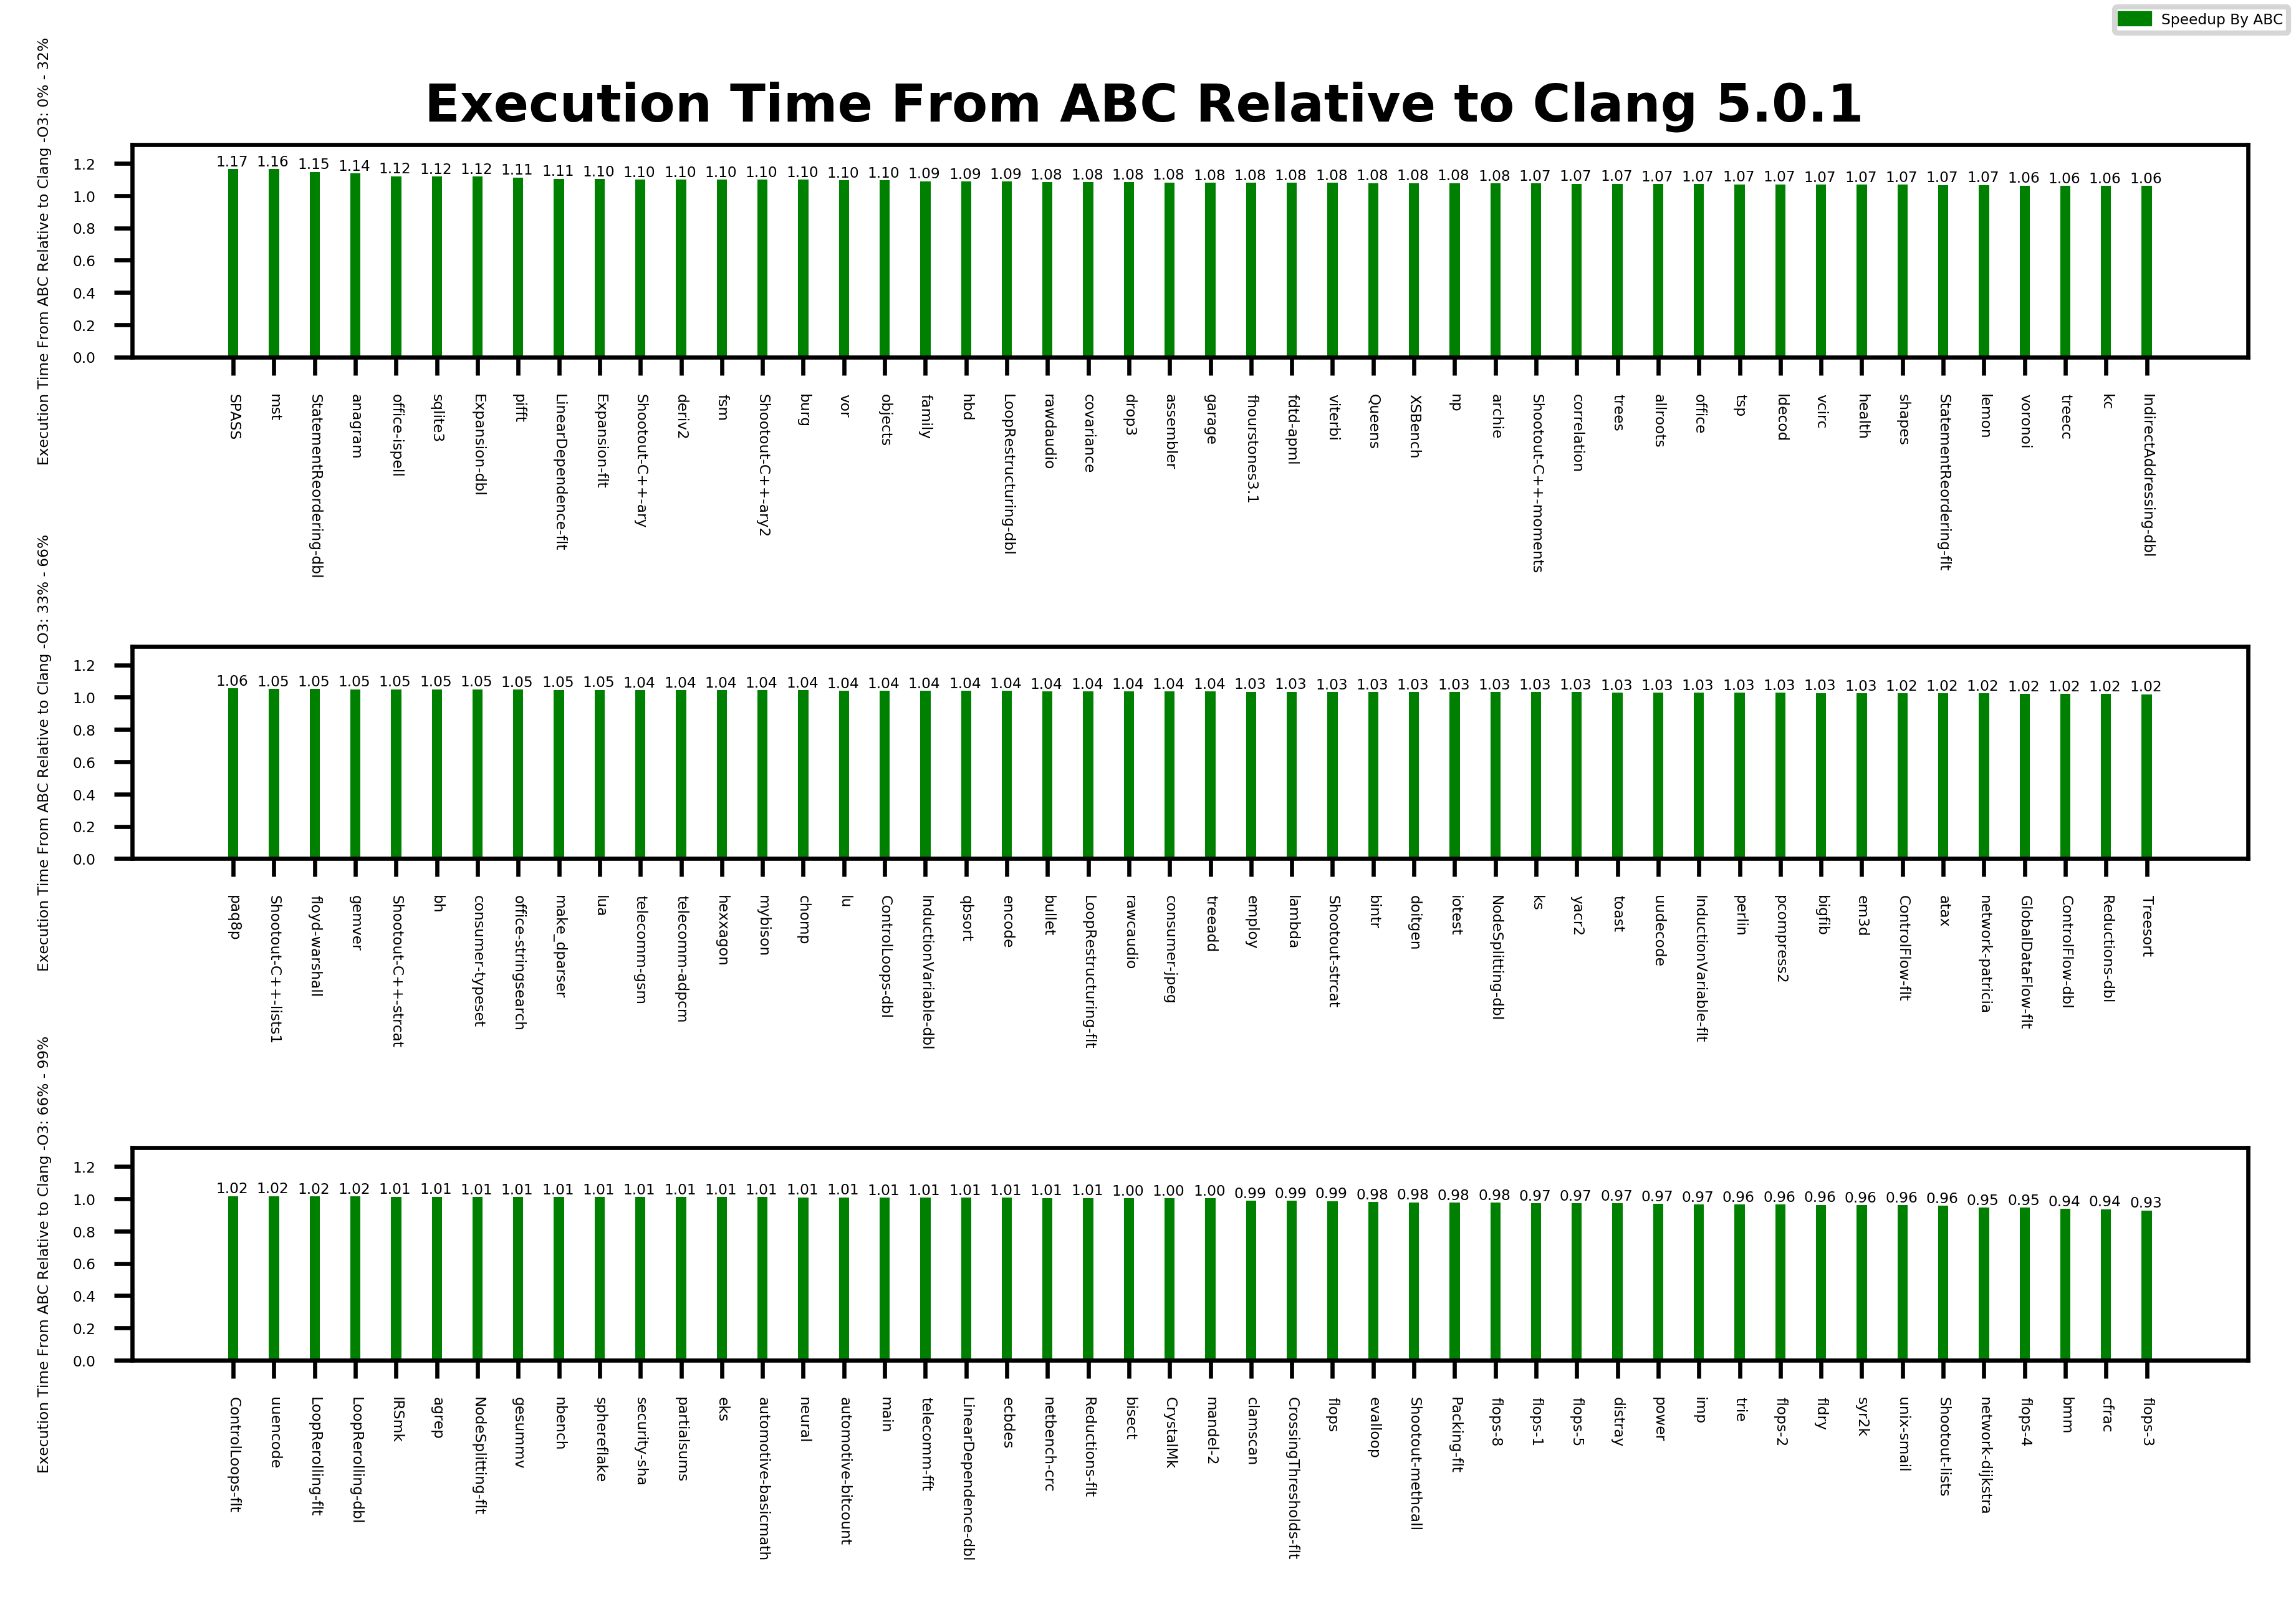

[['SPASS', 1.1656808886629502], ['mst', 1.1637738230339314], ['StatementReordering-dbl', 1.1476784348394902], ['anagram', 1.1365278833226056], ['office-ispell', 1.1199017107924516], ['sqlite3', 1.1177854785138843], ['Expansion-dbl', 1.1176022923821303], ['pifft', 1.1129333825407124], ['LinearDependence-flt', 1.105055889967311], ['Expansion-flt', 1.101930552164914], ['Shootout-C++-ary', 1.098865108965658], ['deriv2', 1.0982882513403605], ['fsm', 1.0982370681146594], ['Shootout-C++-ary2', 1.098172864457286], ['burg', 1.097677758705456], ['vor', 1.0964332096321998], ['objects', 1.095437675823396], ['family', 1.0895166729570298], ['hbd', 1.087495020530009], ['LoopRestructuring-dbl', 1.0865812627029743], ['rawdaudio', 1.0835363057207186], ['covariance', 1.0828353050674913], ['drop3', 1.0825407295557434], ['assembler', 1.0820173943564526], ['garage', 1.0811162558537437], ['fhourstones3.1', 1.0802175290811522], ['fdtd-apml', 1.0799734447791638], ['viterbi', 1.0787327067480177], ['Queens', 1.0

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from operator import itemgetter

%matplotlib inline 

def GraphGenerator_AutoLabel(rects, ax, location):
    """
    Helper function
    """
    horizontalAlign = 'center'
    if location == "up":
        verticalAlign='bottom'
    else:
        verticalAlign='top'

    for rect in rects:
        h = rect.get_height()
        label = "%.2f" % (h)
        if location == "up":
            h = h*1.0
        else:
            h = h*1.0
        ax.text(rect.get_x()+0.1, h, label,
                ha=horizontalAlign, va=verticalAlign)

def DrawBarChart(Inputs, Title, Ymax = None, Ymin = None):
    """
    Draw the bar chart
    """
    '''
    Prepare chart input
    '''
    NameList = []
    Speedup = []
    for item in Inputs:
        NameList.append(item[0])
        Speedup.append(item[1])

    x = NameList
    y = Speedup
    '''
    Draw bar chart
    '''
    plt.rc('font', size=2.8)
    fig = plt.figure(dpi=600)
    width = 0.25 # the width of the bars

    # Split into N bar chart
    splitCount = 3
    step = len(x) // splitCount
    patch_speedup = mpatches.Patch(color='green', label='Speedup By ABC')
    percentage = 0.33

    for i in range(splitCount):
        indexStart = i*step
        indexEnd = indexStart + int(percentage * len(x))

        x_sub = x[indexStart:indexEnd]
        y_sub = y[indexStart:indexEnd]
        #x_sub_order = [x for x in range(indexStart, indexEnd)]
        index = np.arange(len(x_sub))
        ax = fig.add_subplot(splitCount, 1 , i+1)

        rects = ax.bar(index, y_sub, width, color='green')
        # Do we need to limit the y axis?
        if Ymin == None and Ymax != None:
            plt.ylim(ymax=Ymax)
        elif Ymin != None and Ymax == None:
            plt.ylim(ymin=Ymin)
        elif Ymin != None and Ymax != None:
            plt.ylim(ymin=Ymin, ymax=Ymax)

        y_label_loc = "up"
        GraphGenerator_AutoLabel(rects, ax, y_label_loc)

        XLength = len(x)
        ax.set_ylabel('Execution Time From ABC Relative to Clang -O3: {}% - {}%'.format(
            round((indexStart/XLength)*100), round((indexEnd/XLength)*100)))
        
        ax.set_xticks(index)
        ax.set_xticklabels(x_sub, rotation=270)

    fig.legend( handles=[patch_speedup] )
    fig.suptitle(Title, fontweight='bold', fontsize=10, y=1.0)
    plt.tight_layout()
    plt.show()
    fig.savefig(Title + ".png", dpi=fig.dpi, bbox_inches='tight')

        
if __name__ == '__main__':
    ABC_cycles_mean = json.load(open("ABC_cycles_mean.json"))
    Orig_cycles_mean = json.load(open("Orig_cycles_mean.json"))
    Orig_cycles_sigma = json.load(open("Orig_cycles_sigma.json"))
    # Due to not all the results are available(some may be -1, which indicating failure)
    AvailableKeys = []
    for target, cycles in ABC_cycles_mean.items():
        if cycles != -1:
            AvailableKeys.append(target)
    SpeedupDict = {}
    '''
    SpeedupDict contains all the information that we need =)
    '''
    TotalSpeedup = 0.0
    for target in AvailableKeys:
        new = ABC_cycles_mean[target]
        old = Orig_cycles_mean[target]
        speedup = (old - new) / old
        sigma = Orig_cycles_sigma[target]
        SpeedupDict[target] = {}
        SpeedupDict[target]['new'] = new
        SpeedupDict[target]['old'] = old
        SpeedupDict[target]['speedup'] = speedup
        SpeedupDict[target]['sigma'] = sigma
        TotalSpeedup += speedup
    AvgSpeedup = TotalSpeedup / len(AvailableKeys)
    '''
    Discard the speedup or slow-down less than twice sigma
    '''
    SelectedSpeedupDict = SpeedupDict.copy()
    for target, info in SpeedupDict.items():
        if abs(info['new'] - info['old']) < 2*info['sigma']:
            SelectedSpeedupDict.pop(target, None)
    print("Number of programs that are our targets: {}".format(len(Orig_cycles_mean)))
    print("Number of programs that built successfully by ABC: {}".format(len(SpeedupDict)))
    print("Number of programs that speedup by ABC(larger than twice sigma): {}".format(len(SelectedSpeedupDict)))
    print("Average speedup of all the ABC built programs is: {}".format(AvgSpeedup))
    print("-------------------------------------------------------------------------------------")
    
    GraphData = []
    for target, info in SelectedSpeedupDict.items():
        GraphData.append([target, info['speedup']+1] )
    '''
    Sort the data in descending order for plotting graph.
    '''
    GraphData.sort(key=itemgetter(1), reverse=True)
    DrawBarChart(Inputs=GraphData, Title="Execution Time From ABC Relative to Clang 5.0.1", Ymax = GraphData[0][1]+0.15, Ymin = 0)
    print(GraphData)
        
        
        
        
